# Introduction

This notebook demonstrates the new capabilities introduced in `Amazon Titan Image Generator v2`, a powerful tool for generating and manipulating images using text prompts and reference visuals.


Specifically, in this notebook, we will be focusing on **Color Conditioning** feature, which controls the color palette of generated images by providing a list of hex color codes, adhering to brand color guidelines. 

Optionally, users can also supply a reference image to generate visuals that combine the specified color palette with the styling inherited from the reference.



# Pre-requisite

Before diving into the code examples, ensure you have the following

- An AWS account with access to Amazon Bedrock

- Enable Titan Image Generator v2 model access in Amazon Bedrock

- The necessary IAM permissions to invoke Amazon Bedrock models

- AWS SDK for Python (Boto3) installed


In [ ]:
%pip install boto3 numpy pillow matplotlib --quiet

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
import base64
import io
import json
import logging
import boto3
import numpy as np

from PIL import Image
from io import BytesIO
from pathlib import Path
from matplotlib import pyplot as plt

bedrock_runtime_client = boto3.client("bedrock-runtime")

In [ ]:
# Define function for display
def plot_images(base_images, color_codes, prompt, seed, ref_image_path=None):
    if ref_image_path:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        num_subplots = 3
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        num_subplots = 2

    # Plot Hex Color
    num_colors = len(color_codes)
    color_width = 0.8 / num_colors
    for i, color_code in enumerate(color_codes):
        x = i * color_width
        rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
        axes[0].add_patch(rect)
    axes[0].set_xlim(0, 0.8)
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Color Codes')
    axes[0].axis('off')

    if ref_image_path:
        reference_image = Image.open(ref_image_path)
        max_size = (300, 300)
        reference_image.thumbnail(max_size)
        axes[1].imshow(np.array(reference_image))
        axes[1].set_title('Reference Image\n')
        axes[1].axis('off')
        image_index = 2
    else:
        image_index = 1

    axes[image_index].imshow(np.array(base_images[0]))
    if ref_image_path:
        axes[image_index].set_title(f'Image Generated Based on Reference\nSeed: {seed}')
    else:
        axes[image_index].set_title(f'Image Generated\nSeed: {seed}')
    axes[image_index].axis('off')

    print(f"Prompt: {prompt}\n")
    plt.tight_layout()
    plt.show()

In [ ]:
# Define function to save the output
def save_image(base64_image, output_file):
    image_bytes = base64.b64decode(base64_image)
    image = Image.open(io.BytesIO(image_bytes))
    image.save(output_file)

### Color Conditioning

Color conditioning enables control over the color palette of generated images by providing a list of hex color codes. This is useful for adhering to brand guidelines or specific design requirements.

In [ ]:
# Define the prompt, color code and path to store the generated images
prompt = "A cartoon image showing a laptop on the cloud"
hex_color_code = ['#FF9900', '#232F3E', '#F2F2F2', '#000000', '#146EB4']
seed = 10 # Can be any random number between 0 to 214783647

# Create output folder and specify output path
Path("Output/").mkdir(parents=True, exist_ok=True)
output_save_path = "Output/cartoon_laptop.png" 

Prompt: A cartoon image showing a laptop on the cloud



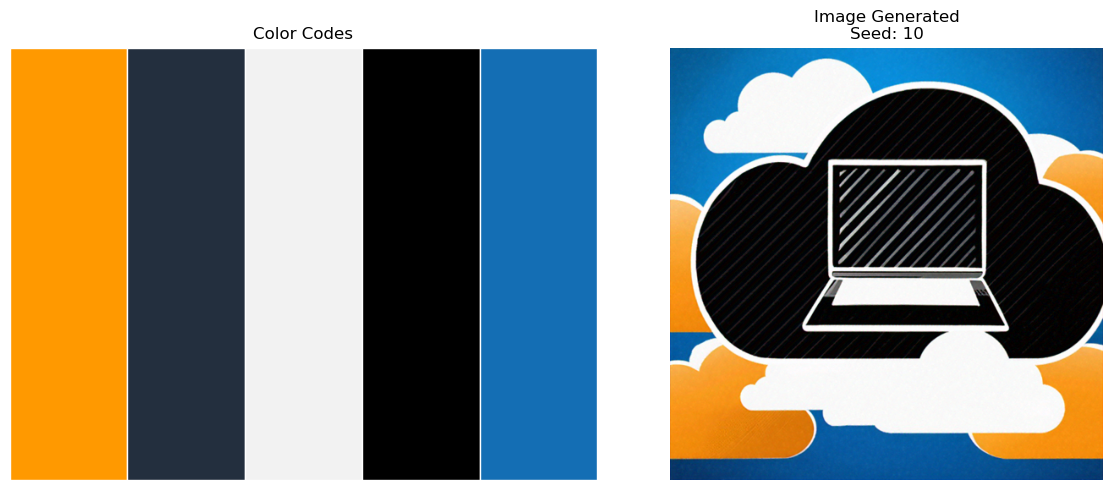

In [5]:
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, hex_color_code, prompt, seed)

Additionally, users can upload a single reference image that is similar to their desired output. The model will then generate images that follow the style and fashion of this reference image while incorporating the specified color palette.

In [ ]:
# Define the prompt, reference image, color code and path to store the generated images
prompt = "a ladybug on the flower"
reference_image_path = "Data/carton_ladybug.png"
hex_color_code = ["#ff8080", "#ffb280", "#ffe680", "#ffe680"]
seed = 10 # Can be any random number between 0 to 214783647

output_save_path = "Output/ladybug_flower.png" 

Prompt: a ladybug on the flower



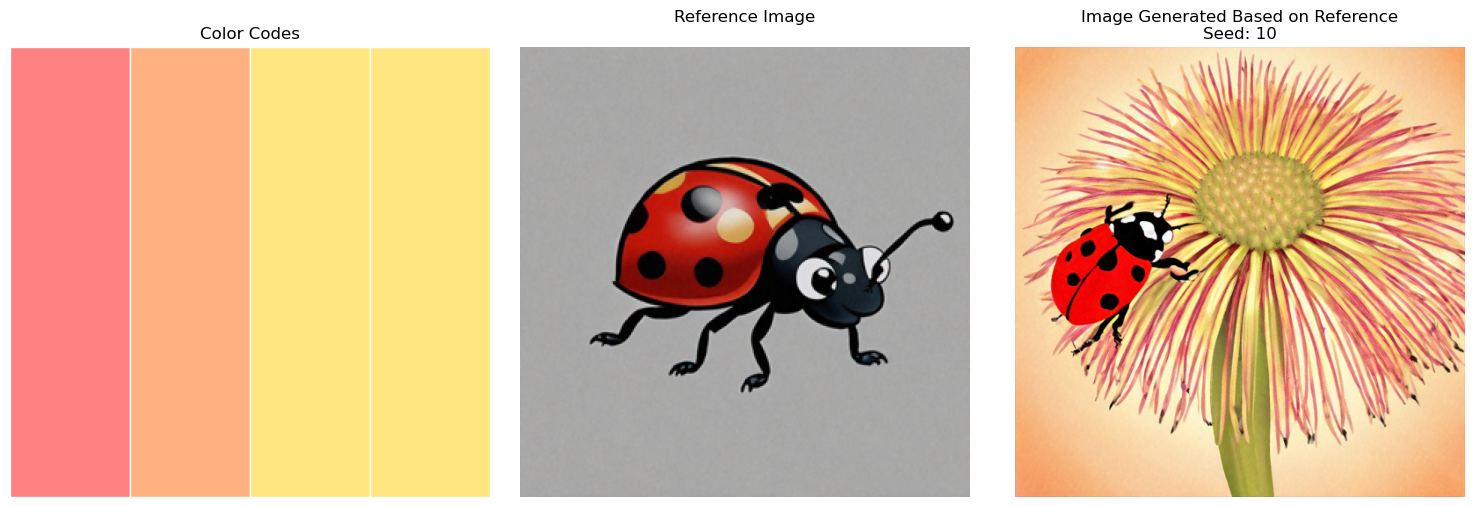

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
    
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code,
        "referenceImage": reference_image_base64
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, hex_color_code, prompt, seed, reference_image_path)

# Take Away

Amazon Titan Image Generator v2 introduces advanced features such as image conditioning, color conditioning and background removal, enhacing the capabilities of AI-driven image generation. 

We encourage users to explore these new functionalities within Amazon Bedrock to experience the expanded potential for creating precise, customized visual contents.